In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# lftab = freqeuncy table / ldtab = input time history / dr = damping ratio / dtime = integration time step(default = 1/(20*fmax))
# it = input type (0=displacement / 1=acceleration)
# output list
# - displacement(relative to base excitation)
# - velocity    (relative to base excitation)
# - acceleration
# - pseudo velocity
# - pseudo acceleration

def resp(lftab,ldtab,dr,dtime,it):
    def newmark_parameter(dt):
        r = 0.005; alpha = (1/4)*((1+r)**2); delta = 0.5 + r;
        a = np.zeros(8);
        a[0] = 1/(alpha*dt*dt); a[1] = delta/(alpha*dt); a[2] = 1/(alpha*dt); a[3] = 1/(2*alpha)-1;
        a[4] = delta/alpha - 1; a[5] = (dt/2)*((delta/alpha)-2); a[6] = dt*(1-delta); a[7] = delta*dt;
        return a;
    def DERIV(X,Y):
        N = len(Y); YY = np.zeros(N);
        YY[0] = (Y[1]-Y[0])/(X[1]-X[0]); Y[N-1] = (Y[N-1]-Y[N-2])/(X[N-1]-X[N-2]);
        for n in range(N-2):
            YY[n+1] = (((Y[n+2]-Y[n+1])/(X[n+2]-X[n+1]))*(X[n+1]-X[n]) + ((Y[n+1]-Y[n])/(X[n+1]-X[n]))*(X[n+2]-X[n+1]))/(X[n+2]-X[n]);
        return YY;
    def INTEG(X,Y,C1):
        N = len(Y); YY = np.zeros(N);
        YY[0] = C1;
        for n in range(1,N):
            YY[n] = YY[n-1] + (1/2)*(Y[n]+Y[n-1])*(X[n]-X[n-1]);
        return YY;      
        
    freq = lftab; th = ldtab; zeta = dr; dt = dtime;
    a = newmark_parameter(dt);
    umax,vmax,acmax,pvmax,pamax = np.zeros(len(freq)),np.zeros(len(freq)),np.zeros(len(freq)),np.zeros(len(freq)),np.zeros(len(freq));
    u,v,ac = np.zeros(len(th)),np.zeros(len(th)),np.zeros(len(th));
    ru,rv,rac = np.zeros(len(th)),np.zeros(len(th)),np.zeros(len(th));
    if it == 0:  # input type = displacement
        N = len(th);
        time = np.arange(N)*dt;
        vth = DERIV(time,th);       
        for fl in range(len(freq)):
            w = 2*np.pi*freq[fl]; m = 1; c = 2*zeta*w; k = w**2;
            F = 2*zeta*w*vth + w**2*th;
            Fe = a[0]*m + a[1]*c + k;
            
            for n in range(len(th-1)):
                u[n+1] = (F[n+1] + m*(a[0]*u[n]+a[2]*v[n]+a[3]*ac[n])+c*(a[1]*u[n]+a[4]*v[n]+a[5]*ac[n]))/Fe;
                v[n+1] = a[1]*(u[n+1]-u[n]) - a[4]*v[n] - a[5]*ac[n];
                ac[n+1] = a[0]*(u[n+1]-u[n]) -a[2]*v[n] - a[3]*ac[n];
            ru = u - th; rv = v - vth;
            umax[fl] = max(abs(ru)); vmax[fl] = max(abs(rv)); acmax[fl] = max(abs(ac));
            pvmax[fl] = umax[fl]*w; pamax[fl] = umax[fl]*w*w;
    if it == 1: # input type = acceleration
        N = len(th);
        time = np.arange(N)*dt;
        vth = INTEG(time,th,0); dth = INTEG(time,vth,0);
        F = -th;
        for fl in range(len(freq)):
            w = 2*np.pi*freq[fl]; m = 1; c = 2*zeta*w; k = w**2;            
            Fe = a[0]*m + a[1]*c + k;          
            for n in range(len(th)-1):
                ru[n+1] = (F[n+1] + m*(a[0]*ru[n]+a[2]*rv[n]+a[3]*rac[n])+c*(a[1]*ru[n]+a[4]*rv[n]+a[5]*rac[n]))/Fe;
                rv[n+1] = a[1]*(ru[n+1]-ru[n]) - a[4]*rv[n] - a[5]*rac[n];
                rac[n+1] = a[0]*(ru[n+1]-ru[n]) -a[2]*rv[n] - a[3]*rac[n];
            ac = rac + th;
            umax[fl] = max(abs(ru)); vmax[fl] = max(abs(rv)); acmax[fl] = max(abs(ac));
            pvmax[fl] = umax[fl]*w; pamax[fl] = umax[fl]*w*w;
    return freq,umax,vmax,acmax,pvmax,pamax;

In [11]:
lftab = np.linspace(0,1000,1001)/10; dt = 1/(20*max(lftab));
t = np.arange(10001)*dt;
gth = 10*np.sin(2*np.pi*t) + 13*np.sin(2*np.pi*3*t+np.pi/1.3) + 17*np.sin(2*np.pi*5*t+np.pi/1.7);
freq,umax,vmax,acmax,pvmax,pamax = resp(lftab,gth,0.00,dt,1)

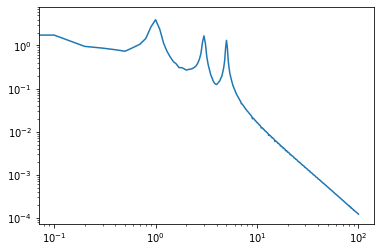

In [12]:
plt.plot(freq,umax); plt.xscale('log'); plt.yscale('log');